In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
import os
# Location of Zip File
drive_path = "/content/gdrive/MyDrive/Colab Notebooks/GSoC"
os.chdir(drive_path)
!unzip -q 'lens'

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dir = "/content/gdrive/MyDrive/GSoC/lenses"
train_data = datasets.ImageFolder(train_dir,transform=transform)
# train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=32, num_workers=2)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,num_workers=2,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=32,num_workers=2,sampler=valid_sampler)

In [ ]:
print(len(validation_loader))

32


In [ ]:
Vit_model = torchvision.models.vit_b_16(pretrained=True)
Vit_model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
import torch.nn as nn
Vit_model.head =  nn.Linear(768,2)
Vit_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Vit_model.to(device)

cuda:0


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Vit_model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = Vit_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss ))
            running_loss = 0.0

print('Finished Training of Vision Transformer')

[1,   100] loss: 87.3940804
[1,   200] loss: 71.4630967
[2,   100] loss: 71.5474192
[2,   200] loss: 71.5153617
[3,   100] loss: 70.0857508
[3,   200] loss: 69.6185375
[4,   100] loss: 69.5072957
[4,   200] loss: 69.2332034
[5,   100] loss: 69.6309339
[5,   200] loss: 69.3402918
[6,   100] loss: 67.6816031
[6,   200] loss: 68.2261437
[7,   100] loss: 67.4812344
[7,   200] loss: 66.4854941
[8,   100] loss: 65.9390634
[8,   200] loss: 65.3473342
[9,   100] loss: 64.4267110
[9,   200] loss: 63.5199547
[10,   100] loss: 63.3275600
[10,   200] loss: 58.7384424
[11,   100] loss: 56.2808935
[11,   200] loss: 52.2123962
[12,   100] loss: 50.7994626
[12,   200] loss: 48.7779187
[13,   100] loss: 49.1120362
[13,   200] loss: 42.4585393
[14,   100] loss: 41.1360990
[14,   200] loss: 41.2689725
[15,   100] loss: 36.6025240
[15,   200] loss: 37.7779073
[16,   100] loss: 32.0650440
[16,   200] loss: 35.4010422
[17,   100] loss: 31.6817361
[17,   200] loss: 28.6255918
[18,   100] loss: 28.7241528
[18

In [ ]:
# torch.save(ResNet_model.state_dict(), "/content/gdrive/MyDrive/Documentation/ResNet")
torch.save(Vit_model, "/content/gdrive/MyDrive/Colab Notebooks/GSoC/Vit_final")

In [ ]:
vit_model = torch.load("/content/gdrive/MyDrive/Colab Notebooks/GSoC/Vit_final")
vit_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 89 %


In [ ]:
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_curve 
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
correct = 0
total = 0
labels = []
y_scores1 = []
y_scores2 = []
with torch.no_grad():
    for data in validation_loader:
        images, label = data[0].to(device), data[1].to(device)
        outputs = vit_model(images)
        prob1 = F.softmax(outputs,dim=1)[:,0]
        prob2 = F.softmax(outputs,dim=1)[:,1]
        y_score1 = prob1.cpu().detach().numpy()
        y_score2 = prob2.cpu().detach().numpy()
        label = label.cpu().numpy()
        y_scores1 = np.concatenate((y_scores1, y_score1))
        y_scores2 = np.concatenate((y_scores2, y_score2))
        labels = np.concatenate((labels, label))

In [ ]:
fpr1, tpr1,_= roc_curve(label_binarize(labels, classes=range(2))[:,0], y_scores2)

0.9659512835285833
ROC graph


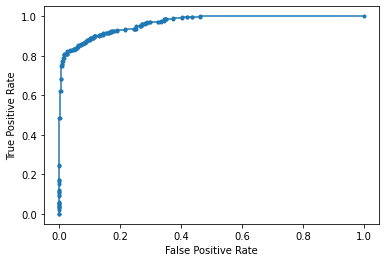

In [ ]:
from sklearn.metrics import auc
ans = auc(fpr1,tpr1)
print(ans)
print("ROC graph")
plt.plot(fpr1,tpr1,marker='.')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate' )
plt.show()